Amy Fan 12-2023

# Math With Bad Drawings

From the Math with Bad Drawings post called [Data Science Contest: Which U.S. Cities are the True Twins?](https://mathwithbaddrawings.com/2023/12/04/data-science-contest-which-u-s-cities-are-the-true-twins/)

Now, here comes the puzzle. It’s a two-part challenge:

* Find a complete list of all pairs of U.S. cities that meet this definition (at most 10 miles apart, with at least 200,000 people each, and populations within a factor of two).
* From this list of twin cities, make a cogent and persuasive case for which pair deserves to be called THE twin cities.

Data source: 

(219, 7)


<AxesSubplot: >

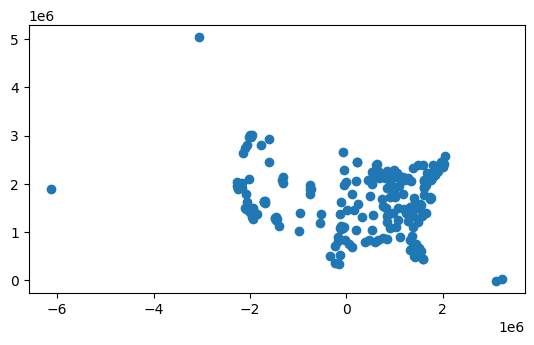

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from libpysal import weights

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

MILES = 10
METERS = MILES * 1609.344

# Removing basically NYC
NYC = ['Brooklyn', 'Queens', 'Manhattan', 'Staten Island']

columns = ['city', 'state_id', 'population', 'lat', 'lng']

cities = pd.read_csv("simplemaps_uscities_basicv1.77/uscities.csv")[columns]
cities = cities[~cities.city.isin(NYC)]
cities['name'] = cities['city'] + ", " + cities['state_id']

# use conus albers
gdf = gpd.GeoDataFrame(cities, geometry=gpd.points_from_xy(cities['lng'], cities['lat'])).set_crs("EPSG:4326").to_crs("EPSG:5070")

# filter for cities with more than 200000 people 
pop200k = gdf[gdf.population>=200000]
print(pop200k.shape)
pop200k.plot() # okay yeah this kind of looks like the US

In [2]:
pop200k.head()

,city,state_id,population,lat,lng,name,geometry
0,New York,NY,18908608,40.6943,-73.9249,"New York, NY",POINT (1833393.877 2178657.051)
1,Los Angeles,CA,11922389,34.1141,-118.4068,"Los Angeles, CA",POINT (-2032603.641 1468467.567)
2,Chicago,IL,8497759,41.8375,-87.6866,"Chicago, IL",POINT (684628.546 2122697.416)
3,Miami,FL,6080145,25.7840,-80.2101,"Miami, FL",POINT (1591844.480 436576.014)
4,Houston,TX,5970127,29.7860,-95.3885,"Houston, TX",POINT (59090.422 745822.673)


In [3]:
adj = weights.DistanceBand.from_dataframe(pop200k, threshold=METERS, ids = 'name', silence_warnings=True).to_adjlist(True, True)[['focal', 'neighbor']]

adj

,focal,neighbor
0,"New York, NY","Jersey City, NJ"
1,"Miami, FL","Hialeah, FL"
2,"Washington, DC","Arlington, VA"
3,"Phoenix, AZ","Glendale, AZ"
4,"Minneapolis, MN","St. Paul, MN"
5,"Denver, CO","Aurora, CO"
6,"Las Vegas, NV","Spring Valley, NV"
7,"Bronx, NY","Yonkers, NY"
8,"Mission Viejo, CA","Irvine, CA"
9,"Mesa, AZ","Gilbert, AZ"


In [4]:
pop = pop200k[['name', 'population']].set_index('name').to_dict()['population']

adj['focal_pop'] = adj['focal'].map(pop)
adj['neighbor_pop'] = adj['neighbor'].map(pop)
adj['ratio'] = adj['focal_pop']/adj['neighbor_pop']

In [6]:
all_twins = adj[adj.ratio<=2]
all_twins.sort_values('ratio')

,focal,neighbor,focal_pop,neighbor_pop,ratio
27,"Enterprise, NV","Spring Valley, NV",219566,217441,1.009773
20,"Chandler, AZ","Gilbert, AZ",272439,262249,1.038856
13,"Santa Ana, CA","Irvine, CA",313818,297868,1.053547
26,"San Bernardino, CA","Fontana, CA",220821,208087,1.061196
15,"Newark, NJ","Jersey City, NJ",306247,287146,1.066520
11,"Anaheim, CA","Santa Ana, CA",348204,313818,1.109573
9,"Mesa, AZ","Gilbert, AZ",497752,262249,1.898013


Wait a second, Minneapolis and St. Paul aren't on this list! 

In [7]:
adj

,focal,neighbor,focal_pop,neighbor_pop,ratio
0,"New York, NY","Jersey City, NJ",18908608,287146,65.850153
1,"Miami, FL","Hialeah, FL",6080145,224362,27.099709
2,"Washington, DC","Arlington, VA",5116378,235764,21.701269
3,"Phoenix, AZ","Glendale, AZ",4064275,245685,16.542626
4,"Minneapolis, MN","St. Paul, MN",2892569,309751,9.338369
5,"Denver, CO","Aurora, CO",2687458,383496,7.007786
6,"Las Vegas, NV","Spring Valley, NV",2248047,217441,10.338653
7,"Bronx, NY","Yonkers, NY",1472654,209730,7.021666
8,"Mission Viejo, CA","Irvine, CA",642211,297868,2.156025
9,"Mesa, AZ","Gilbert, AZ",497752,262249,1.898013
